In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
from dateutil.easter import easter
import matplotlib.pyplot as plt
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from pandas.tseries.frequencies import to_offset
from sklearn.preprocessing import MinMaxScaler
import torch
from arch import arch_model
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split

In [3]:
monthly_data = pd.read_csv("monthly_data.csv")

c:\Users\30467\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006998. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\30467\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006997. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\30467\AppDa

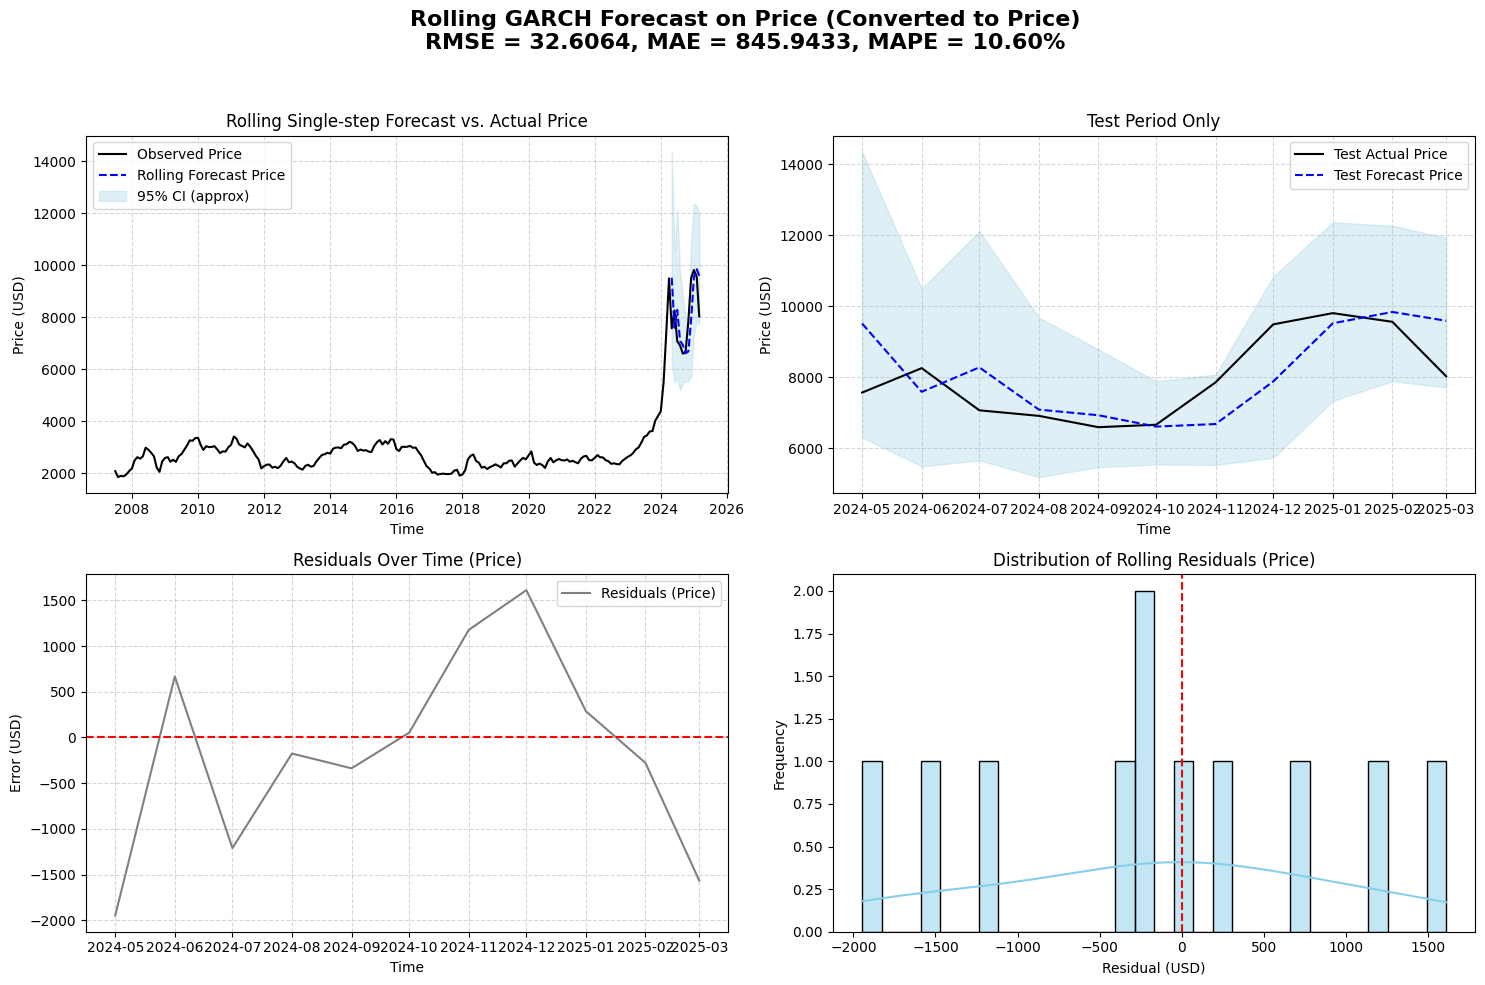

In [7]:
monthly_data["Month"] = pd.to_datetime(monthly_data["Month"], errors='coerce')

monthly_data_ts = monthly_data.set_index("Month")

price_series = monthly_data_ts["Price_NY"]
log_return_series = monthly_data_ts["log_return_rate"].dropna()

n = len(log_return_series)
train_size = int(n * 0.95)

train_return_series = log_return_series.iloc[:train_size]
test_return_series = log_return_series.iloc[train_size:]
test_dates = test_return_series.index

# Rolling GARCH forecast
rolling_mean_forecasts = {}
rolling_variances = {}
predicted_prices = {}
ci_lower_prices = {}
ci_upper_prices = {}
actual_prices = {}

for test_date in test_dates:
    current_train = log_return_series.loc[:test_date].iloc[:-1]
    model = arch_model(current_train, vol='Garch', p=1, q=1, mean='Constant', dist='normal')
    result = model.fit(disp='off')
    
    forecast = result.forecast(horizon=1)
    mean_forecast = forecast.mean.iloc[-1, 0]
    variance_forecast = forecast.variance.iloc[-1, 0]
    
    rolling_mean_forecasts[test_date] = mean_forecast
    rolling_variances[test_date] = variance_forecast
    
    prev_price = price_series.loc[price_series.index < test_date].iloc[-1]
    pred_price = prev_price * np.exp(mean_forecast)
    
    # 95% confidence interval in log-return space
    z = 1.96
    lower_log = mean_forecast - z * np.sqrt(variance_forecast)
    upper_log = mean_forecast + z * np.sqrt(variance_forecast)
    
    lower_price = prev_price * np.exp(lower_log)
    upper_price = prev_price * np.exp(upper_log)
    
    predicted_prices[test_date] = pred_price
    ci_lower_prices[test_date] = lower_price
    ci_upper_prices[test_date] = upper_price
    actual_prices[test_date] = price_series.loc[test_date]

# Convert to Series
predicted_price_series = pd.Series(predicted_prices)
actual_price_series = pd.Series(actual_prices)
ci_lower_series = pd.Series(ci_lower_prices)
ci_upper_series = pd.Series(ci_upper_prices)
residuals = actual_price_series - predicted_price_series

rmse = np.sqrt(root_mean_squared_error(actual_price_series, predicted_price_series))
mae = mean_absolute_error(actual_price_series, predicted_price_series)
mape = mean_absolute_percentage_error(actual_price_series, predicted_price_series) * 100

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(
    f"Rolling GARCH Forecast on Price (Converted to Price)\n"
    f"RMSE = {rmse:.4f}, MAE = {mae:.4f}, MAPE = {mape:.2f}%",
    fontsize=16, weight="bold"
)

# 图1：全数据范围内观察值与滚动预测
axes[0, 0].plot(price_series, label="Observed Price", color="black")
axes[0, 0].plot(predicted_price_series, label="Rolling Forecast Price", color="blue", linestyle="--")
axes[0, 0].fill_between(predicted_price_series.index, ci_lower_series, ci_upper_series, 
                        color="lightblue", alpha=0.4, label="95% CI (approx)")
axes[0, 0].set_title("Rolling Single-step Forecast vs. Actual Price", fontsize=12)
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Price (USD)")
axes[0, 0].legend()
axes[0, 0].grid(True, linestyle="--", alpha=0.5)

# 图2：仅测试期间的实际值与预测值
axes[0, 1].plot(actual_price_series, label="Test Actual Price", color="black")
axes[0, 1].plot(predicted_price_series, label="Test Forecast Price", color="blue", linestyle="--")
axes[0, 1].fill_between(predicted_price_series.index, ci_lower_series, ci_upper_series, 
                        color="lightblue", alpha=0.4)
axes[0, 1].set_title("Test Period Only", fontsize=12)
axes[0, 1].set_xlabel("Time")
axes[0, 1].set_ylabel("Price (USD)")
axes[0, 1].legend()
axes[0, 1].grid(True, linestyle="--", alpha=0.5)

# 图3：残差随时间变化
axes[1, 0].plot(residuals, label="Residuals (Price)", color="gray")
axes[1, 0].axhline(0, color="red", linestyle="--")
axes[1, 0].set_title("Residuals Over Time (Price)", fontsize=12)
axes[1, 0].set_xlabel("Time")
axes[1, 0].set_ylabel("Error (USD)")
axes[1, 0].legend()
axes[1, 0].grid(True, linestyle="--", alpha=0.5)

# 图4：残差分布直方图
sns.histplot(residuals, bins=30, kde=True, color="skyblue", ax=axes[1, 1])
axes[1, 1].axvline(0, color="red", linestyle="--")
axes[1, 1].set_title("Distribution of Rolling Residuals (Price)", fontsize=12)
axes[1, 1].set_xlabel("Residual (USD)")
axes[1, 1].set_ylabel("Frequency")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

c:\Users\30467\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006998. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


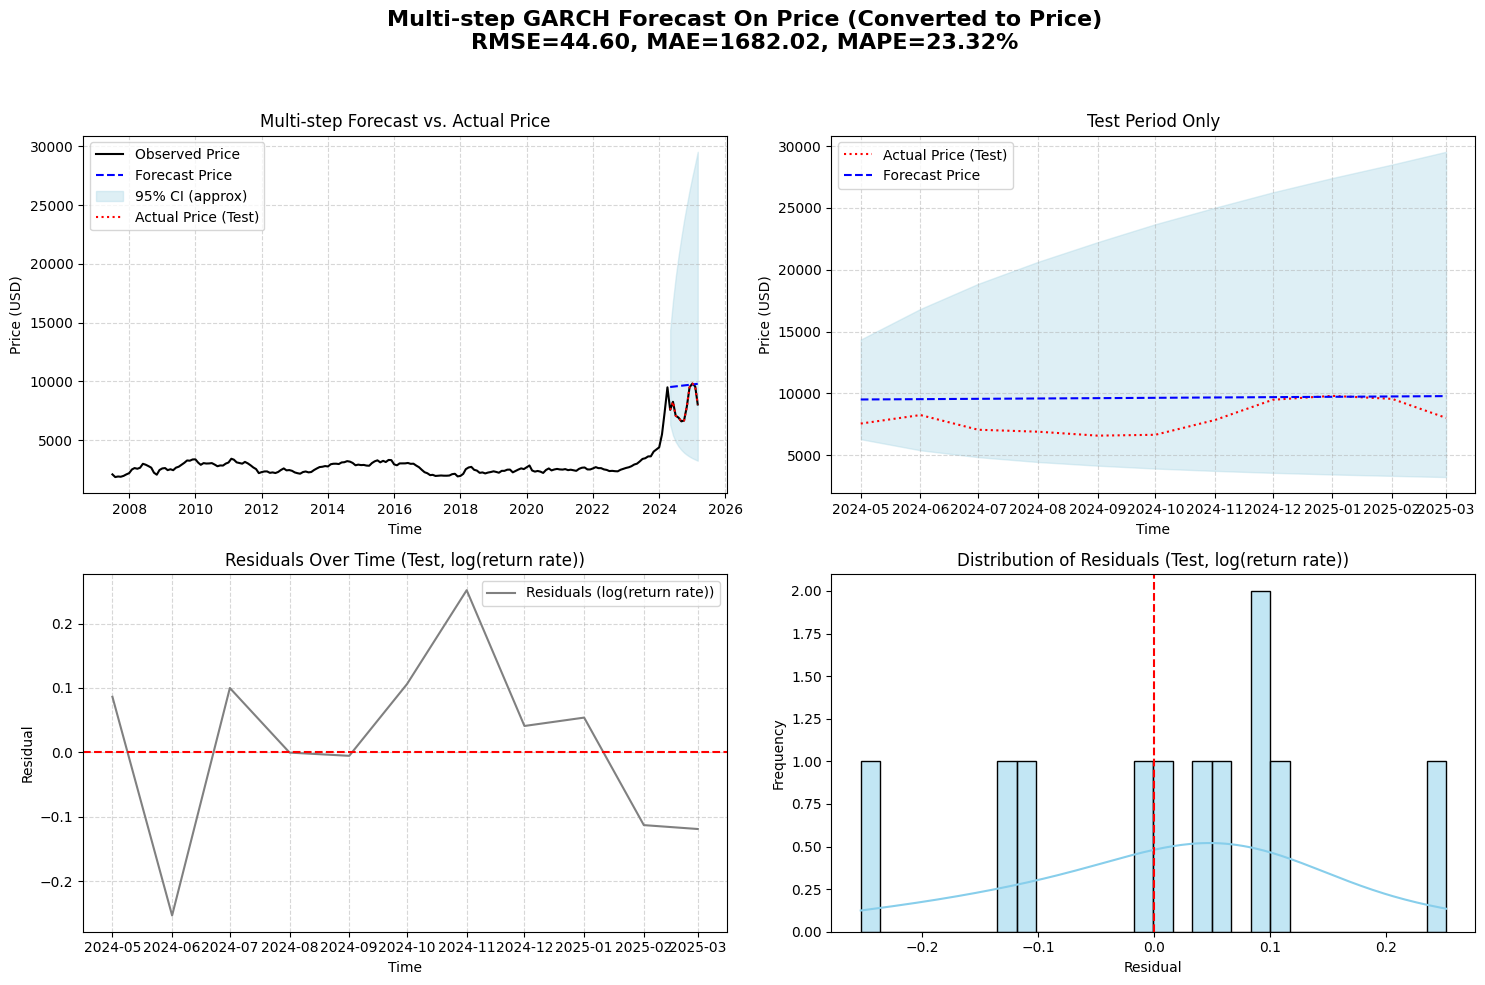

In [6]:
monthly_data["Month"] = pd.to_datetime(monthly_data["Month"], errors='coerce')
monthly_data_ts = monthly_data.set_index("Month")
price_series = monthly_data_ts["Price_NY"]
log_return_series = monthly_data_ts["log_return_rate"].dropna()

# 数据划分
n = len(log_return_series)
train_size = int(n * 0.95)
train_return_series = log_return_series.iloc[:train_size]
test_return_series = log_return_series.iloc[train_size:]
test_index = test_return_series.index
test_steps = len(test_return_series)

# 在训练集上拟合 GARCH 模型
garch_model = arch_model(train_return_series, vol='Garch', p=1, q=1, mean='Constant')
garch_result = garch_model.fit(disp='off')

# 多步预测（对数收益率预测）
forecast = garch_result.forecast(horizon=test_steps)
mean_forecast = forecast.mean.values[-1]   # 长度为 test_steps 的数组
var_forecast = forecast.variance.values[-1]

# 转换为累计对数收益率及其标准差
cum_return = np.cumsum(mean_forecast)
cum_std = np.sqrt(np.cumsum(var_forecast))

# 以训练集最后一个价格作为起点，并转换为带时间索引的 Series（价格空间）
base_price = price_series.iloc[train_size - 1]
predicted_prices = pd.Series(base_price * np.exp(cum_return), index=test_index)
ci_upper = pd.Series(base_price * np.exp(cum_return + 1.96 * cum_std), index=test_index)
ci_lower = pd.Series(base_price * np.exp(cum_return - 1.96 * cum_std), index=test_index)
actual_prices = price_series.iloc[train_size:]

# 计算评价指标与价格空间残差
rmse = np.sqrt(root_mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
mape = mean_absolute_percentage_error(actual_prices, predicted_prices) * 100
residuals = actual_prices.values - predicted_prices.values

# -------------------------------
# 计算测试集在对数收益率空间的残差
# 预测的对数收益率（test_steps 长度）用 mean_forecast，转换为 Series 便于后续对齐索引
predicted_log_returns = pd.Series(mean_forecast, index=test_index)
test_residuals_log = test_return_series - predicted_log_returns
# -------------------------------

# 创建图形和子图
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(
    f"Multi-step GARCH Forecast On Price (Converted to Price)\n"
    f"RMSE={rmse:.2f}, MAE={mae:.2f}, MAPE={mape:.2f}%",
    fontsize=16, weight="bold"
)

# (1) 全系列价格 + 预测
axes[0, 0].plot(price_series, label="Observed Price", color="black")
axes[0, 0].plot(predicted_prices.index, predicted_prices, label="Forecast Price", color="blue", linestyle="--")
axes[0, 0].fill_between(predicted_prices.index, ci_lower, ci_upper, color="lightblue", alpha=0.4, label="95% CI (approx)")
axes[0, 0].plot(actual_prices.index, actual_prices, label="Actual Price (Test)", color="red", linestyle="dotted")
axes[0, 0].set_title("Multi-step Forecast vs. Actual Price", fontsize=12)
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Price (USD)")
axes[0, 0].legend()
axes[0, 0].grid(True, linestyle="--", alpha=0.5)

# (2) 仅测试期放大
axes[0, 1].plot(actual_prices, label="Actual Price (Test)", color="red", linestyle="dotted")
axes[0, 1].plot(predicted_prices.index, predicted_prices, label="Forecast Price", color="blue", linestyle="--")
axes[0, 1].fill_between(predicted_prices.index, ci_lower, ci_upper, color="lightblue", alpha=0.4)
axes[0, 1].set_title("Test Period Only", fontsize=12)
axes[0, 1].set_xlabel("Time")
axes[0, 1].set_ylabel("Price (USD)")
axes[0, 1].legend()
axes[0, 1].grid(True, linestyle="--", alpha=0.5)

# (3) 测试集残差（在 log_return_rate 空间）
axes[1, 0].plot(test_residuals_log, label="Residuals (log(return rate))", color="gray")
axes[1, 0].axhline(0, color="red", linestyle="--")
axes[1, 0].set_title("Residuals Over Time (Test, log(return rate))", fontsize=12)
axes[1, 0].set_xlabel("Time")
axes[1, 0].set_ylabel("Residual")
axes[1, 0].legend()
axes[1, 0].grid(True, linestyle="--", alpha=0.5)

# (4) 残差分布直方图（在 log_return_rate 空间）
sns.histplot(test_residuals_log, bins=30, kde=True, color="skyblue", ax=axes[1, 1])
axes[1, 1].axvline(0, color="red", linestyle="--")
axes[1, 1].set_title("Distribution of Residuals (Test, log(return rate))", fontsize=12)
axes[1, 1].set_xlabel("Residual")
axes[1, 1].set_ylabel("Frequency")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()